# Import
Block for storing all imported libraries.

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import neuralfoil as nf
import aerosandbox as asb
import aerosandbox.numpy as np

# Constants
A block for storing all constants required during the calculation. Separated into a distinct block for easier access to them.

First of all we must define the characteristics that we want for the future UAV. In this field we can use "House of quality" by ... [1]. With help of this method, we can identify the most necessary parameters for the future design.

**Add some information about house of quality and "build" it.** Create parametric research and link this to house of quality. Show how important define all parametrs befor design (or this is first step of design)

[1] Akao, Y. (1990). Quality Function Deployment: Integrating Customer Requirements into Product Design.

In [15]:
class DesignConstants:
    g = 9.81 

    eng_q = 2 # Number of engines
    con_cell_num = 6 # Number of cells in series in one battery string
    cell_U = 4.2 # Nominal cell voltage, V
    prop_D = 22 # Propeller diameter, inches

    LD_ratio_cruise = 14 # Cruise lift-to-drag ratio (L/D)
    prop_efficiency = 0.75 # Propeller efficiency η_p
    battery_specific_energy = 216 # Battery specific energy, Wh/kg
    payload_mass = 1.5 # Payload mass, kg
    flight_time = 90 # Required flight time, minutes
    flight_time_hr = flight_time / 60 # Required flight time, hours
    cruise_speed = 90 # Cruise speed, km/h
    cruise_speed_ms = cruise_speed / 3.6 # Cruise speed, m/s
    takeoff_mass_reserve = 1.07 # Take-off mass margin factor
    battery_mass_reserve = 1.1 # Battery mass margin factor
    k = 0.3 # Empirical coefficient for propeller mass formula
    n = 2.3 # Empirical exponent for propeller mass formula
    prop_fasteners = 0.015 # Additional mass of propeller fasteners per powerplant
    e = 0.78 # Oswald efficiency factor
    k_structure = 0.3 # Structure mass fraction

    stall_speed = 55 # stall speed (kph)
    air_density_sea_level = 1.225 # air density on takeoff (sea level)
    max_lift_coefficient_stat = 1.4 # maximum wing lift coefficient (statistically)
    min_lift_coefficient_stat = -0.8 # minimum wing lift coefficient (from the aerofoil polar)
    derivative_max_lift_coefficient_stat = 5.25 # derivative of max lift coefficient (by statistic)
    WP = 0.1 # energy armament (by prototype)

    # Battery parameters
    series_cells_n = 6
    parallel_cells_n = 4 
    cell_U_min = 3
    cell_U_max = 4.2
    cell_capacity_nom_A = 4.2 
    cell_capacity_nom_W = 15.5
    max_current_cell = 45
    cell_mass = 0.07
    battery_mass_coef = 1.12
    screws_n = 2
    blades_n = 2
    Kp = 0.0995

    screws_n = 2
    blades_n = 2
    Kp = 0.0995

    # 
    Re_cruise = 511979
    SwetS = 2 # According to the table from the sources
    AR = 8 # Aspect ratio (Presumably, need to correct or use Aerosandbox optimization)
    air_density_cruise = 1.1117
    dynamic_viscosity_cruise = 0.00001787
    prop_efficiency_cruise = 0.75
    battery_depth = 0.3

    # Wing parametrs
    taper_ratio = 0.57

    # Speed on transition
    Vy_hover = 0.0
    Vy_climb = 3.0
    Vy_ceiling = 0.5

    # Prop characteristics
    Vtip = 80  # м/с
    solidity = 0.1
    Cd_blade = 0.02
    induced_power_factor_hover = 1.15
    induced_power_factor_climb = 1.15
    # disc_loading_max_diameter = 0.246
    total_disc_area_max = 0.2463 * 2

    # Angels
    alpha_rotor_trans = 0

    # Wing aerodynamic
    wing_loading_optimum_airborne = 300  # Н/м²

    climbe_rate = 3 # m/s
    ceiling_rate_of_climb = 0.5 # m/s
    max_lift_coefficient = 1.4

    # Airfoil parameters
    number_point_on_chord = 30
    phi = math.radians(90 / (number_point_on_chord - 1))
    profile_thickness = 0.12
    profile_curv = 0.04
    max_curv_point = 0.4
    profile_max_lift_coefficient = 1.55

    # Wing characteristics
    wing_narrowing = 0.5
    sweep_angel_1_2 = 0
    angel_of_incedence = 0
    dihedral_angel = 0
    wing_tip_twist = 0

    drag_coefficient_constant = 0.045161009

    vertical_stab_aspect_ratio = 2

    # Геометрические параметры килей (примерные, будут масштабироваться)
    # Центральный киль (вверх)
    central_root_chord = 0.50
    central_tip_chord  = 0.25
    central_span       = 0.80   # высота киля

    # Боковые кили (вниз)
    side_root_chord = 0.40
    side_tip_chord  = 0.20
    side_span       = 0.60

    fraction_central = 0.40   # 40% общей площади — центральный киль вверх

## Zero approximation of takeoff mass
A very rough statistical estimate based only on payload mass [2]:

$$
m_{0}=5.147m_{пн}^{0.849}
$$

[2] Gudmundsson, S. (2013). General Aviation Aircraft Design.

In [16]:
def calculate_zero_approximation_mass(payload_mass):
    """Calculate zero approximation of takeoff mass based on payload."""
    return 5.147 * payload_mass ** 0.849

## Calculation of takeoff mass
Next approximations of takeoff mass calculation need more parametrs, than just payload mass.
Structure mass can be calculated []:
$$\frac{m_{str}}{m_{0}}=0.3$$
**Where**:
- $m_{str}$ - Aircraft structural mass
- $m_{0}$ - Zero approximation mass

Required power []:
$$P_{req}=\frac{m_{0} \cdot g \cdot V}{\frac{L}{D} \cdot n_{prop}}$$
**Where**:
- $P_{req}$ - Total required engine power, W
- $V$ - Cruise speed, m/s
- $\frac{L}{D}$ - Aerodynamic quality (lift-to-drag ratio)
- $n_{prop}$ - Propeller efficiency

Engine mass []:
$$m_{eng}=0.889P_{max}^{-0.288}U_{max}^{0.1588}$$
**Where**:
- $m_{eng}$ - Engine mass, kg
- $P_{max}$ - max continuous power of one motor, W
- $U_{max}$ - Maximum battery voltage, V

Propeller mass []:
$$m_{prop}=k \cdot D^{n}$$
**Where**:
- $m_{prop}$ - Propeller mass
- $D$ - Propeller diameter, inches

Battery mass []:
$$m_{bat}=\frac{E_{req}}{p_{bat}}=\frac{P_{req} \cdot t_{flight}}{p_{bat}}$$
**Where**:
- $m_{bat}$ - Battery mass
- $E_{req}$ - 
- $p_{bat}$ - Battery specific energy, Wh/kg
- $t_{flight}$ - Time of flight

First approximation takeoff mass []:
$$m_{0}^{(i+1)}=m_{str}^{(i)}+m_{eng}^{(i)}+m_{bat}^{(i)}+m_{payload}+m_{eq}$$
**Where**:
- $m_{0}^{(i+1)}$ - First approximation UAV mass

The difference between the zeroth and first approximation []:
$$e=\frac{m_{0}^{(i+1)}-m_{0}^{(i)}}{m_{0}^{(i+1)}} \cdot 100%$$


In [17]:
def iterate_takeoff_mass(const, tol=0.5, max_iter=50):
    """
    Iteratively converge takeoff mass until tolerance is met.
    Returns dict with final values and iteration history.
    """
    m0 = calculate_zero_approximation_mass(const.payload_mass)
    g = 9.81
    history = []

    for i in range(max_iter):
        W0 = m0 * g
        V_cruise = const.cruise_speed / 3.6

        # Required cruise power
        P_req = W0 * V_cruise / (const.LD_ratio_cruise * const.prop_efficiency)
        P_per_motor = P_req / const.eng_q

        # Motor mass (statistical, 6S)
        U_pack = 6 * 4.2
        m_motor_one = 0.889 * (P_per_motor ** -0.288) * (U_pack ** 0.1588)

        # Propeller mass
        m_prop_one = const.k * (const.prop_D ** const.n) / 1000.0

        # Powerplant total
        m_powerplant = const.eng_q * (m_motor_one + m_prop_one) + const.prop_fasteners * const.eng_q

        # Battery
        E_req_wh = P_req * const.flight_time_hr
        m_battery = (E_req_wh / const.battery_specific_energy) * const.battery_mass_reserve

        # Structure & equipment
        m_structure = const.k_structure * m0
        m_eq = 0.3  # equipment fixed mass

        # New mass estimate
        m0_new = (const.payload_mass + m_structure + m_eq + m_powerplant + m_battery)
        m0_new *= const.takeoff_mass_reserve

        error = abs(m0_new - m0) / m0_new * 100.0
        history.append({
            "iter": i+1, "m0_kg": round(m0, 4), "m0_new_kg": round(m0_new, 4),
            "error_%": round(error, 3), "P_req_W": round(P_req, 1),
            "m_battery_kg": round(m_battery, 4), "m_powerplant_kg": round(m_powerplant, 4)
        })

        if error < tol:
            print(f"✓ Mass convergence in {i+1} iterations (Δ < {tol} %)")
            break

        m0 = m0_new

    result = {
        "final_m0_kg": m0_new,
        "m_battery_kg": m_battery,
        "m_powerplant_kg": m_powerplant,
        "P_req_W": P_req,
        "history": pd.DataFrame(history)
    }
    return result

def print_mass_summary(mass_result, const):
    """Print summary of mass iteration."""
    print(f"\n{'='*60}")
    print(f"MASS CONVERGENCE SUMMARY")
    print(f"{'='*60}")
    print(f"Final takeoff mass: {mass_result['final_m0_kg']:.3f} kg")
    print(f"Battery mass: {mass_result['m_battery_kg']:.3f} kg")
    print(f"Powerplant mass: {mass_result['m_powerplant_kg']:.3f} kg")
    print(f"Required power: {mass_result['P_req_W']:.1f} W")
    print(f"{'='*60}\n")

After obtaining the function for calculating the mass of the spacecraft, you need to call it and retrieve the final data. The function will perform as many iterations as necessary until it achieves a 1% difference in mass.

# Calculation of wing parametrs

## Calculation of wing loading parametrs

SI units are used in the calculations, so it is necessary to convert the speed to SI units:
$$V_{stall} = \frac{V_{kph}}{3.6}$$
**Where**:
- $V_{kph}$ - Stall velocity in kilometer per hour

Dynamic pressure on stall is calculated using the following formula []:
$$q_{stall} = \frac{1}{2} \rho_{stall} V_{stall}^{2}$$
**Where**:
- $\rho$ - Air density on sea level

Wing loading on stall  is calculated using the following formula []:
$$\frac{W}{S} = q_{stall} C_{L}$$
**Where**:
- $C_{L}$ - Lift coefficient statistics for such UAVs

In [18]:
def calculate_wing_loading_params(const):
    """Calculate wing loading at stall condition."""
    stall_speed_ms = const.stall_speed / 3.6
    dynamic_pressure = 0.5 * const.air_density_sea_level * stall_speed_ms ** 2
    wing_loading = const.max_lift_coefficient_stat * dynamic_pressure
    return {
        "stall_speed_ms": stall_speed_ms,
        "dynamic_pressure": dynamic_pressure,
        "wing_loading": wing_loading
    }

## Calculation wing geometry
This block calculates the take-off weight required to achieve the specified flight range.

We need to calculate requred wing area by formula []:
$$S_{wing} = \frac{W_{0}}{W/S}$$
**Where**:
- $W_{0}$ - Takeoff weight of UAV


In [27]:
def calculate_wing_geometry(m0_final, wing_loading, const):
    """Calculate wing area, span, and chord dimensions."""
    g = 9.81
    take_off_weight = m0_final * g
    S_wing = take_off_weight / wing_loading
    wingspan = np.sqrt(const.AR * S_wing)
    root_chord = (2 * S_wing) / (wingspan * (1 + const.taper_ratio))
    tip_chord = const.taper_ratio * root_chord
    MAC = (2/3) * root_chord * (1 + const.taper_ratio + const.taper_ratio ** 2) / (1 + const.taper_ratio)
    
    return {
        "S_wing": S_wing,
        "wingspan": wingspan,
        "root_chord": root_chord,
        "tip_chord": tip_chord,
        "MAC": MAC
    }

## Calculation cruise aerodynamic

Drag coefficient on zero lift []:
$$C_{D0} = C_{fe} \frac{S_{wet}}{S_{ref}}$$
**Where**:
- $\frac{S_{wet}}{S_{ref}}$ - By statistic for this type of UAVs

Induced drag coefficient is calculate using this formula []:
$$K = \frac{1}{\pi AR e}$$
**Where**:
- $AR$ - Wing aspect ratio
- $e$ - Oswald coefficient

Available wing loading in cruise mode []:
$$\frac{W}{S}_{cruise} = \frac{W}{S} \cdot \frac{W_{cruise}}{W_{0}}$$
**Where**:
- $\frac{W_{cruise}}{W_{0}}$ - ?

Dynamic pressuare on cruise []:
$$q_{cruise} = \frac{1}{2} \rho_{cruise} V_{cruise}^{2}$$

Aerodynamic quality on cruise []:
$$\frac{L}{D} = \frac{1}{\frac{q_{cruise} C_{D0}}{W/S} + (W/S) \frac{K}{q_{cruise}}}$$

We need to calculate requred wing area by formula []:
$$S_{wing} = \frac{W_{0}}{W/S}$$
**Where**:
- $W_{0}$ - Takeoff weight of UAV

In [ ]:
def calculate_cruise_aerodynamics(const, wing_geo):
    """Calculate cruise aerodynamic parameters."""
    fric_coef = 0.74 / (const.Re_cruise ** 0.2)
    zero_lift_drag = const.SwetS * fric_coef
    induced_drag_factor_K = 0.3183 / const.AR / const.e
    
    dynamic_pressure_cruise = 0.5 * const.air_density_cruise * const.cruise_speed_ms ** 2
    wing_loading = wing_geo["S_wing"] * const.g / (const.payload_mass * const.g)  # rough estimate
    
    CL_opt = np.sqrt(zero_lift_drag / induced_drag_factor_K)
    CD_opt = zero_lift_drag + induced_drag_factor_K * CL_opt ** 2
    aerodynamic_quality = CL_opt / CD_opt
    
    return {
        "zero_lift_drag": zero_lift_drag,
        "induced_drag_factor_K": induced_drag_factor_K,
        "dynamic_pressure_cruise": dynamic_pressure_cruise,
        "CL_opt": CL_opt,
        "CD_opt": CD_opt,
        "aerodynamic_quality": aerodynamic_quality
    }

# Сalculation of battery parameters
After previos calculation battery parametrs need to be calculated. For this need to be a lot of input parametrs.

Add this block later)))

In [19]:
def calculate_battery_params(const, m_battery):
    """Calculate battery pack parameters from cell specifications."""
    battery_weight = m_battery * const.g
    
    cell_total = const.series_cells_n * const.parallel_cells_n
    pack_cell_U_min = const.series_cells_n * const.cell_U_min
    pack_cell_U_max = const.series_cells_n * const.cell_U_max
    pack_cell_U = const.series_cells_n * const.cell_U
    pack_cell_capacity_A = const.parallel_cells_n * const.cell_capacity_nom_A
    pack_cell_capacity_W = const.parallel_cells_n * const.cell_capacity_nom_W
    pack_max_current = const.parallel_cells_n * const.max_current_cell
    pack_cell_mass = cell_total * const.cell_mass * const.battery_mass_coef
    
    total_battery_mass = pack_cell_mass
    total_battery_capacity = total_battery_mass / const.battery_mass_coef / const.cell_mass * const.parallel_cells_n
    
    return {
        "cell_total": cell_total,
        "pack_U_min": pack_cell_U_min,
        "pack_U_max": pack_cell_U_max,
        "pack_U": pack_cell_U,
        "pack_capacity_Ah": pack_cell_capacity_A,
        "pack_capacity_Wh": pack_cell_capacity_W,
        "pack_max_current": pack_max_current,
        "pack_mass": total_battery_mass,
        "battery_weight": battery_weight
    }

def print_battery_summary(battery_params):
    """Print battery parameters summary."""
    print(f"\n{'='*60}")
    print(f"BATTERY PACK SUMMARY")
    print(f"{'='*60}")
    print(f"Total cells: {battery_params['cell_total']}")
    print(f"Pack voltage: {battery_params['pack_U']:.1f} V (range: {battery_params['pack_U_min']:.1f}-{battery_params['pack_U_max']:.1f} V)")
    print(f"Pack capacity: {battery_params['pack_capacity_Ah']:.1f} Ah / {battery_params['pack_capacity_Wh']:.1f} Wh")
    print(f"Max current: {battery_params['pack_max_current']:.1f} A")
    print(f"Pack mass: {battery_params['pack_mass']:.3f} kg")
    print(f"{'='*60}\n")

# Step 3: Constant analysis

## VTOL UAV Constraint Diagram

### Fixed-Wing Mode

#### Stall speed
Wing loading for stall speed:

$$
\frac{W}{S} = \frac{1}{2} \rho V_s^2 C_{L_{\text{max}}}
$$

**Where:**
- $W/S$ = Wing loading (N/m²)
- $V_s$ = Stall speed (m/s)
- $C_{L_{\text{max}}}$ = Maximum lift coefficient
- $\rho$ = Air density (kg/m³)

#### Maximum Speed Constraint
Power loading for maximum speed:

$$
\frac{P}{W} = \frac{1}{\eta_p} \left( \frac{1}{2} \rho V_{\text{max}}^3 \frac{C_{D_0}}{W/S} + \frac{2K}{\rho V_{\text{max}}} \frac{W}{S} \right)
$$

**Where:**
- $\eta_p$ = Propeller efficiency
- $V_{\text{max}}$ = Maximum speed (m/s)
- $C_{D_0}$ = Zero-lift drag coefficient
mb rate (Tessure (Pa)
- $\theta$ = Tilt angle (degrees)
- $V$ = Transition speed (m/s)
- $k_i$ = Induced power correction factor

#### Rate of Climb Constraint
Power loading for climb rate:

$$
\frac{P}{W} = \frac{1}{\eta_p} \left( \frac{V_c}{V} + \frac{qC_{D_0}}{W/S} + \frac{K}{q} \frac{W}{S} \right)V
$$

**Where:**
- $V_c$ = Climb rate (m/s)
- $V$ = Flight speed (m/s)
- $q = \frac{1}{2}\rho V^2$ = Dynamic pressure (Pa)


The maximum rate of climb speed for the given wing loading:
$$
V_{\text{climb}} = \sqrt{\frac{2 \cdot (W/S)}{\rho}} \cdot \left( \frac{K}{C_{D_0}} \right)^{1/4}
$$

**Where:**
- $V_{\text{climb}}$ = Best climb speed (m/s)
- $W/S$ = Wing loading (N/m²)
- $\rho$ = Air density (kg/m³)
- $K$ = Induced drag factor
- $C_{D_0}$ = Zero-lift drag coefficient

#### Turn Constraint
Thrust-to-weight ratio for turn:

$$
\frac{T}{W} = q \left( \frac{C_{D_0}}{W/S} + \frac{K n^2}{q^2} \frac{W}{S} \right)
$$

Power loading for turn:

$$
\frac{P}{W} = \frac{1}{\eta_p} \left( \frac{T}{W} \cdot V \right) = \frac{1}{\eta_p} \left( q V \frac{C_{D_0}}{W/S} + \frac{K n^2 V}{q} \frac{W}{S} \right)
$$

**Where:**
- $T/W$ = Thrust-to-weight ratio
- $n$ = Load factor
- $q = \frac{1}{2} \rho V^2$ = Dynamic pressure (Pa)

#### Transition Mode Constraint

Power loading during transition:

$$
\frac{P}{W} = \frac{k_i}{\sin(\theta_{tilt})} \sqrt{\frac{-V_{inf}^2}{2} + \sqrt{\left(\frac{V_{inf}^2}{2}\right)^2 + \left(\frac{(DL)}{2\rho\sin(\theta_{tilt})}\right)^2}} + \frac{\rho V_{Tip}^3}{(DL)} \left(\frac{\sigma C_D}{8} (1 + 4.6\mu^2)\right) + \left(0.5\rho_0 V_{inf}^3 C_{D_0} \frac{1}{(W/S)} + \frac{2K}{\rho V_{inf}} (W/S)\right)
$$

**Where:**
- $q$ = Dynamic pressure (Pa)
- $\theta$ = Tilt angle (degrees)
- $V$ = Transition speed (m/s)
- $k_i$ = Induced power correction factor

In [21]:
def calculate_constraint_diagram(const, m0_final, wing_geo, aero_params):
    """Calculate all power and disc loading constraints for the constraint diagram."""
    g = 9.81
    weight_takeoff = m0_final * g
    
    disc_loading_max = weight_takeoff / const.total_disc_area_max
    wing_loading_stall = const.max_lift_coefficient * (const.air_density_sea_level * (const.stall_speed / 3.6) ** 2) / const.prop_efficiency
    
    wing_loading_range = np.arange(150, 600, 1, dtype=float)
    disc_loading_range = np.linspace(20, 200, 200)
    
    # Fixed-wing mode constraints (horizontal flight)
    q = 0.5 * const.air_density_cruise * const.cruise_speed_ms ** 2
    n_load = 1.5
    
    def pw_cruise(wl):
        return (const.cruise_speed_ms / const.prop_efficiency) * (q * aero_params["zero_lift_drag"] / wl + 
                                                                   aero_params["induced_drag_factor_K"] * wl / q)
    
    def pw_turn(wl):
        return (const.cruise_speed_ms / const.prop_efficiency) * (q * aero_params["zero_lift_drag"] / wl + 
                                                                   aero_params["induced_drag_factor_K"] * n_load ** 2 * wl / q)
    
    def pw_climb(wl):
        return (const.climbe_rate / const.prop_efficiency) + (const.cruise_speed_ms / const.prop_efficiency) * \
               (q * aero_params["zero_lift_drag"] / wl + aero_params["induced_drag_factor_K"] * wl / q)
    
    def pw_ceiling(wl):
        return (const.ceiling_rate_of_climb / const.prop_efficiency) + (const.cruise_speed_ms / const.prop_efficiency) * \
               4 * np.sqrt(aero_params["induced_drag_factor_K"] * aero_params["zero_lift_drag"] / 3)
    
    # VTOL mode constraints
    def pw_hover(dl):
        A = weight_takeoff / dl
        P_ind = const.induced_power_factor_hover * np.sqrt(weight_takeoff) / np.sqrt(2 * const.air_density_sea_level * A)
        P_prof = const.air_density_sea_level * A * const.Vtip ** 3 * const.solidity * const.Cd_blade / (8 * weight_takeoff)
        return P_ind + P_prof
    
    def pw_vertical_climb(dl, Vy):
        term1 = Vy * (1 - const.induced_power_factor_climb / 2)
        term2 = (const.induced_power_factor_climb / 2) * np.sqrt(Vy ** 2 + 2 * dl / const.air_density_sea_level)
        term3 = const.air_density_sea_level * const.Vtip ** 3 * const.solidity * const.Cd_blade / (8 * dl)
        return term1 + term2 + term3
    
    # Compute constraint arrays
    pw_cruise_arr = np.array([pw_cruise(wl) for wl in wing_loading_range])
    pw_turn_arr = np.array([pw_turn(wl) for wl in wing_loading_range])
    pw_climb_arr = np.array([pw_climb(wl) for wl in wing_loading_range])
    pw_ceiling_arr = np.array([pw_ceiling(wl) for wl in wing_loading_range])
    
    pw_hover_arr = np.array([pw_hover(dl) for dl in disc_loading_range])
    pw_vclimb_arr = np.array([pw_vertical_climb(dl, const.Vy_climb) for dl in disc_loading_range])
    pw_vceiling_arr = np.array([pw_vertical_climb(dl, const.Vy_ceiling) for dl in disc_loading_range])
    
    return {
        "wing_loading_range": wing_loading_range,
        "disc_loading_range": disc_loading_range,
        "pw_cruise": pw_cruise_arr,
        "pw_turn": pw_turn_arr,
        "pw_climb": pw_climb_arr,
        "pw_ceiling": pw_ceiling_arr,
        "pw_hover": pw_hover_arr,
        "pw_vclimb": pw_vclimb_arr,
        "pw_vceiling": pw_vceiling_arr,
        "wing_loading_stall": wing_loading_stall,
        "disc_loading_max": disc_loading_max
    }

def plot_constraint_diagram(constraints, m0_final, const):
    """Plot hybrid VTOL+Fixed-Wing constraint diagram."""
    fig, ax1 = plt.subplots(figsize=(16, 10))
    
    # Left axis: Wing Loading vs P/W (horizontal flight)
    ax1.plot(constraints['pw_turn'], constraints['wing_loading_range'], ':', color='blue', linewidth=3, label='Turn')
    ax1.plot(constraints['pw_climb'], constraints['wing_loading_range'], '--', color='blue', linewidth=3, label='Climb')
    ax1.plot(constraints['pw_cruise'], constraints['wing_loading_range'], '-.', color='blue', linewidth=3, label='Cruise')
    ax1.plot(constraints['pw_ceiling'], constraints['wing_loading_range'], '-', color='blue', linewidth=3, label='Ceiling')
    ax1.axhline(y=constraints['wing_loading_stall'], color='red', linewidth=3, label='Stall Limit')
    
    ax1.set_xlabel('Power density, P/W (W/N)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Wing loading, W/S (N/m²)', fontsize=14, color='navy')
    ax1.set_title('Hybrid UAV Constraints Diagram (VTOL + Fixed-Wing)', fontsize=16, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(left=0)
    
    # Right axis: Disc Loading vs P/W (vertical flight)
    ax2 = ax1.twinx()
    ax2.plot(constraints['pw_hover'], constraints['disc_loading_range'], '--', color='orange', lw=3, label='Hover')
    ax2.plot(constraints['pw_vclimb'], constraints['disc_loading_range'], '-.', color='orange', lw=3, label='Vert. climb')
    ax2.plot(constraints['pw_vceiling'], constraints['disc_loading_range'], ':', color='orange', lw=3, label='VTOL ceiling')
    ax2.axhline(y=constraints['disc_loading_max'], color='black', linestyle=':', lw=3, label='Prop diameter limit')
    
    ax2.set_ylabel('Disc loading, W/A (N/m²)', fontsize=14, color='darkred')
    ax2.tick_params(axis='y', labelcolor='darkred')
    
    # Combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', bbox_to_anchor=(0.01, 0.99), 
              fontsize=11, framealpha=0.95)
    
    # Annotation box
    ax1.text(0.02, 0.05, f"Mass: {m0_final:.1f} kg\nSpeed: {const.cruise_speed} km/h\nFlight time: {const.flight_time} min",
            transform=ax1.transAxes, fontsize=11, verticalalignment='bottom',
            bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow", edgecolor="gray"))
    
    plt.tight_layout()
    plt.show()

# Step 4: Wing profile
## Calculation of wing profile by characteristics and formulas

In [22]:
## 4. Wing Profile Calculations

def calculate_airfoil_coordinates(const):
    """Generate NACA-like airfoil coordinates using analytical formulas."""
    phi = math.radians(90 / (const.number_point_on_chord - 1))
    
    n_points = range(1, const.number_point_on_chord + 1)
    
    def x_coord(n):
        return 1 - np.cos((n-1) * phi)
    
    def yt_coord(x):
        return 5 * const.profile_thickness * (0.2969 * x ** 0.5 - 0.126 * x - 0.3516 * x ** 2 + 0.2843 * x ** 3 - 0.1015 * x ** 4)
    
    def yc_coord(x):
        if x <= const.max_curv_point:
            return const.profile_curv * (2 * const.max_curv_point * x - x ** 2) / (const.max_curv_point ** 2)
        else:
            return const.profile_curv * ((1 - 2 * const.max_curv_point) + 2 * const.max_curv_point * x - x ** 2) / ((1 - const.max_curv_point) ** 2)
    
    def dyc_dx(x):
        if x <= const.max_curv_point:
            return 2 * const.profile_curv / const.max_curv_point * (1 - x / const.max_curv_point)
        else:
            return 2 * const.profile_curv * (const.max_curv_point - x) / ((1 - const.max_curv_point) ** 2)
    
    x_arr = np.array([x_coord(n) for n in n_points])
    yt_arr = np.array([yt_coord(x) for x in x_arr])
    yc_arr = np.array([yc_coord(x) for x in x_arr])
    dyc_arr = np.array([dyc_dx(x) for x in x_arr])
    theta_arr = np.array([np.arctan(dy) for dy in dyc_arr])
    
    x_upper = x_arr - yt_arr * np.sin(theta_arr)
    x_lower = x_arr + yt_arr * np.sin(theta_arr)
    y_upper = yc_arr + yt_arr * np.cos(theta_arr)
    y_lower = yc_arr - yt_arr * np.cos(theta_arr)
    
    profile_data = pd.DataFrame({
        'n': list(n_points),
        'x': x_arr,
        'yt': yt_arr,
        'yc': yc_arr,
        'dyc_dx': dyc_arr,
        'theta': theta_arr,
        'x_upper': x_upper,
        'y_upper': y_upper,
        'x_lower': x_lower,
        'y_lower': y_lower
    })
    
    return profile_data

def plot_airfoil_profile(profile_data):
    """Plot airfoil upper and lower surfaces."""
    plt.figure(figsize=(10, 4))
    plt.plot(profile_data['x_upper'], profile_data['y_upper'], 'b-', linewidth=2, label='Upper surface')
    plt.plot(profile_data['x_lower'], profile_data['y_lower'], 'r-', linewidth=2, label='Lower surface')
    plt.fill_between(profile_data['x_upper'], profile_data['y_upper'], profile_data['y_lower'], alpha=0.2)
    plt.axis('equal')
    plt.grid(True, alpha=0.3)
    plt.xlabel('Chord position')
    plt.ylabel('Thickness')
    plt.title('Wing Profile (NACA-like)')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Step 5: Wing characteristics

Calculation of unmanned aerial vehicle wing characteristics. Finding MAC.

In [23]:
## 5. Wing Characteristics and Polar

def calculate_wing_characteristics(const, wing_geo):
    """Calculate wing lift and drag characteristics."""
    zero_lift_angle = -90 * const.profile_curv
    critical_angle_profile = zero_lift_angle + const.profile_max_lift_coefficient / (2 * np.pi) * 57.3 + 2
    
    zero_lift_angle_wing = zero_lift_angle + const.angel_of_incedence
    kl = -0.0125 * (1 / const.taper_ratio) ** 2 + 0.0675 * (1 / const.taper_ratio) + 0.8475
    max_lift_coeff_wing = 0.5 * kl * (1 + np.cos(np.radians(const.wing_tip_twist))) * const.profile_max_lift_coefficient
    derivative_lift_coeff = 2 * np.pi * const.AR * np.cos(np.radians(const.wing_tip_twist)) / (2 + const.AR)
    critical_angle_wing = zero_lift_angle_wing + max_lift_coeff_wing / derivative_lift_coeff * 57.3
    
    return {
        "zero_lift_angle": zero_lift_angle_wing,
        "max_lift_coeff": max_lift_coeff_wing,
        "derivative_lift_coeff": derivative_lift_coeff,
        "critical_angle": critical_angle_wing
    }

def calculate_wing_polar(const, wing_chars):
    """Generate wing lift and drag coefficients across angle of attack range."""
    CL_array = np.arange(-0.8, wing_chars["max_lift_coeff"] + 0.1, 0.01)
    CD_array = const.drag_coefficient_constant + (CL_array ** 2) * const.drag_coefficient_constant
    
    polar_data = pd.DataFrame({
        "CL": CL_array,
        "CD": CD_array,
        "L/D": CL_array / CD_array
    })
    
    return polar_data

def plot_wing_polar(polar_data):
    """Plot wing lift-drag polar."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Drag polar
    ax1.plot(polar_data['CD'], polar_data['CL'], 'b-', linewidth=2)
    ax1.set_xlabel('Drag Coefficient (CD)')
    ax1.set_ylabel('Lift Coefficient (CL)')
    ax1.set_title('Wing Drag Polar')
    ax1.grid(True, alpha=0.3)
    
    # L/D efficiency
    valid_idx = polar_data['CL'] > 0
    ax2.plot(polar_data.loc[valid_idx, 'CL'], polar_data.loc[valid_idx, 'L/D'], 'r-', linewidth=2)
    max_ld = polar_data.loc[valid_idx, 'L/D'].max()
    ax2.axhline(max_ld, color='r', linestyle='--', alpha=0.5)
    ax2.set_xlabel('Lift Coefficient (CL)')
    ax2.set_ylabel('L/D Ratio')
    ax2.set_title(f'Wing Efficiency (max L/D ≈ {max_ld:.1f})')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Vertical Stabilisator calculation

In [24]:
## 7. Vertical Stabilizer Calculations

def calculate_vertical_stabilizer(wingspan, S_wing, const):
    """Calculate vertical stabilizer dimensions and scaling."""
    vertical_static_stab_moment = 0.001 * wingspan + 0.03
    vertical_shoulder_stab = -0.002 * wingspan + 0.3
    vertical_relative_stab_area = vertical_static_stab_moment / vertical_shoulder_stab
    vertical_stab_area = vertical_relative_stab_area * S_wing
    vertical_stab_span = np.sqrt(vertical_stab_area * const.vertical_stab_aspect_ratio)
    
    # Distribute area between central and side fins
    S_vt_central = vertical_stab_area * const.fraction_central
    S_vt_side = vertical_stab_area * (1 - const.fraction_central) / 2
    
    # Calculate scaling factors
    central_area_base = (const.central_root_chord + const.central_tip_chord) / 2 * const.central_span
    scale_central = np.sqrt(S_vt_central / central_area_base)
    
    side_area_base = (const.side_root_chord + const.side_tip_chord) / 2 * const.side_span
    scale_side = np.sqrt(S_vt_side / side_area_base)
    
    return {
        "total_area": vertical_stab_area,
        "span": vertical_stab_span,
        "S_central": S_vt_central,
        "S_side": S_vt_side,
        "scale_central": scale_central,
        "scale_side": scale_side
    }

# Drawing of UAV
In this section I will create and draw geometry of UAV  

In [25]:
## 8. Airplane Geometry and Drawing

def build_airplane_model(const, wing_geo, vstab_geo):
    """Build and return Aerosandbox airplane model."""
    airplane = asb.Airplane(
        name="Hybrid VTOL Fixed-Wing UAV",
        xyz_ref=[wing_geo['root_chord'] * 0.25, 0, 0],
        s_ref=wing_geo['S_wing'],
        c_ref=wing_geo['MAC'],
        b_ref=const.AR,
        wings=[
            # Main Wing
            asb.Wing(
                name="Main Wing",
                symmetric=True,
                xsecs=[
                    asb.WingXSec(
                        xyz_le=[0, 0, 0],
                        chord=wing_geo['root_chord'],
                        twist=5,
                        airfoil=asb.Airfoil("naca0012"),
                    ),
                    asb.WingXSec(
                        xyz_le=[wing_geo['root_chord'] - wing_geo['tip_chord'], wing_geo['wingspan']/2, 0],
                        chord=wing_geo['tip_chord'],
                        twist=-2,
                        airfoil=asb.Airfoil("naca0012"),
                    ),
                ],
            ),
            # Central Vertical Fin (up)
            asb.Wing(
                name="Central Fin Up",
                symmetric=False,
                xsecs=[
                    asb.WingXSec(
                        xyz_le=[0.35, 0, 0],
                        chord=const.central_root_chord * vstab_geo['scale_central'],
                        twist=0,
                        airfoil=asb.Airfoil("naca0012"),
                    ),
                    asb.WingXSec(
                        xyz_le=[0.35 + 0.25, 0, const.central_span * vstab_geo['scale_central']],
                        chord=const.central_tip_chord * vstab_geo['scale_central'],
                        twist=0,
                        airfoil=asb.Airfoil("naca0012"),
                    ),
                ],
            ),
            # Left Vertical Fin (down)
            asb.Wing(
                name="Left Fin Down",
                symmetric=False,
                xsecs=[
                    asb.WingXSec(
                        xyz_le=[0.35, wing_geo['wingspan']/4, 0],
                        chord=const.side_root_chord * vstab_geo['scale_side'],
                        twist=0,
                        airfoil=asb.Airfoil("naca0012"),
                    ),
                    asb.WingXSec(
                        xyz_le=[0.35 + 0.20, wing_geo['wingspan']/4, -const.side_span * vstab_geo['scale_side']],
                        chord=const.side_tip_chord * vstab_geo['scale_side'],
                        twist=0,
                        airfoil=asb.Airfoil("naca0012"),
                    ),
                ],
            ),
            # Right Vertical Fin (down)
            asb.Wing(
                name="Right Fin Down",
                symmetric=False,
                xsecs=[
                    asb.WingXSec(
                        xyz_le=[0.35, -wing_geo['wingspan']/4, 0],
                        chord=const.side_root_chord * vstab_geo['scale_side'],
                        twist=0,
                        airfoil=asb.Airfoil("naca0012"),
                    ),
                    asb.WingXSec(
                        xyz_le=[0.35 + 0.20, -wing_geo['wingspan']/4, -const.side_span * vstab_geo['scale_side']],
                        chord=const.side_tip_chord * vstab_geo['scale_side'],
                        twist=0,
                        airfoil=asb.Airfoil("naca0012"),
                    ),
                ],
            ),
        ],
        fuselages=[
            asb.Fuselage(
                name="Fuselage",
                xsecs=[
                    asb.FuselageXSec(xyz_c=[-0.7, 0, 0], width=0.05, height=0.025),
                    asb.FuselageXSec(xyz_c=[-0.6, 0, 0], width=0.3, height=0.15),
                    asb.FuselageXSec(xyz_c=[-0.4, 0, 0], width=0.5, height=0.25),
                    asb.FuselageXSec(xyz_c=[-0.2, 0, 0], width=0.6, height=0.3),
                    asb.FuselageXSec(xyz_c=[0.0, 0, 0], width=0.6, height=0.3),
                    asb.FuselageXSec(xyz_c=[0.2, 0, 0], width=0.6, height=0.3),
                    asb.FuselageXSec(xyz_c=[0.4, 0, 0], width=0.4, height=0.2),
                    asb.FuselageXSec(xyz_c=[0.6, 0, 0], width=0.1, height=0.05),
                ],
            )
        ],
    )
    return airplane

def plot_airplane_views(airplane):
    """Plot three-view drawing of airplane."""
    airplane.draw_three_view()

# Main Execution Block
This cell orchestrates all calculations in the correct order and generates all visualizations.


                        STARTING UAV DESIGN CALCULATION                         

[1/7] Computing takeoff mass convergence...
✓ Mass convergence in 3 iterations (Δ < 0.5 %)

MASS CONVERGENCE SUMMARY
Final takeoff mass: 7.404 kg
Battery mass: 1.318 kg
Powerplant mass: 1.586 kg
Required power: 172.5 W


[2/7] Computing wing loading parameters...
✓ Stall speed: 15.28 m/s
✓ Wing loading at stall: 200.1 N/m²

[3/7] Computing wing geometry...
✓ Wing area: 0.363 m²
✓ Wingspan: 1.704 m
✓ Root chord: 0.271 m
✓ Tip chord: 0.155 m
✓ MAC: 0.218 m

[4/7] Computing cruise aerodynamics...
✓ Zero-lift drag coefficient: 0.10676
✓ Induced drag factor K: 0.05101
✓ Optimal L/D: 6.78

[5/7] Computing battery parameters...

BATTERY PACK SUMMARY
Total cells: 24
Pack voltage: 25.2 V (range: 18.0-25.2 V)
Pack capacity: 16.8 Ah / 62.0 Wh
Max current: 180.0 A
Pack mass: 1.882 kg


[6/7] Computing wing characteristics and polar...
✓ Max lift coefficient: 1.438
✓ Critical angle: 12.8°

[7/7] Computing vertical st

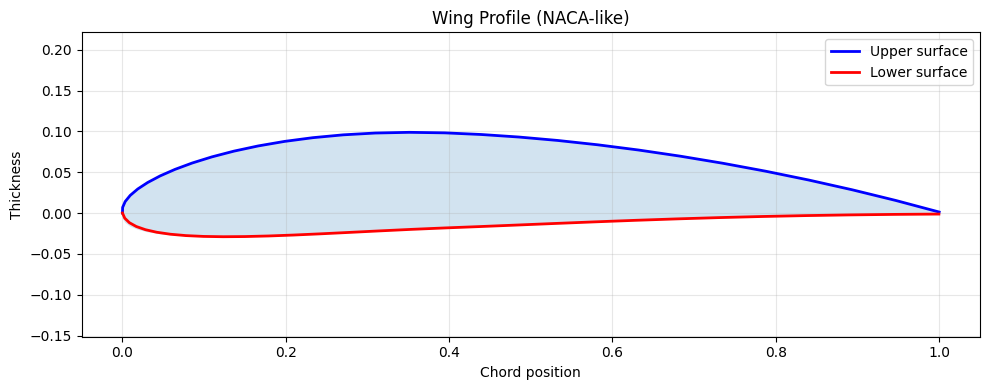


→ Plotting wing drag polar...


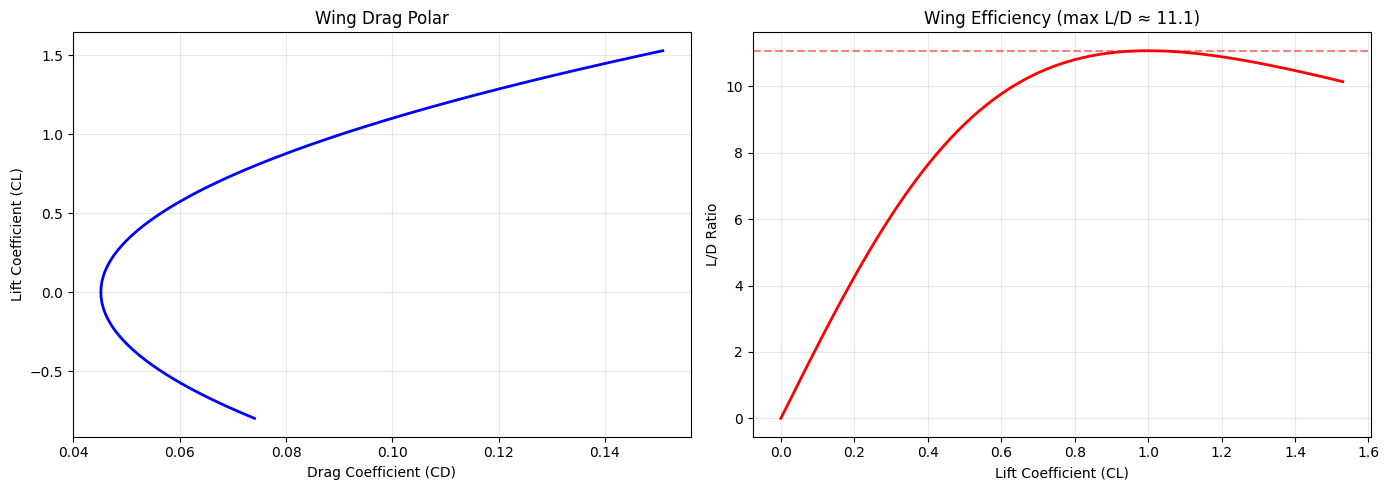


→ Plotting constraint diagram...


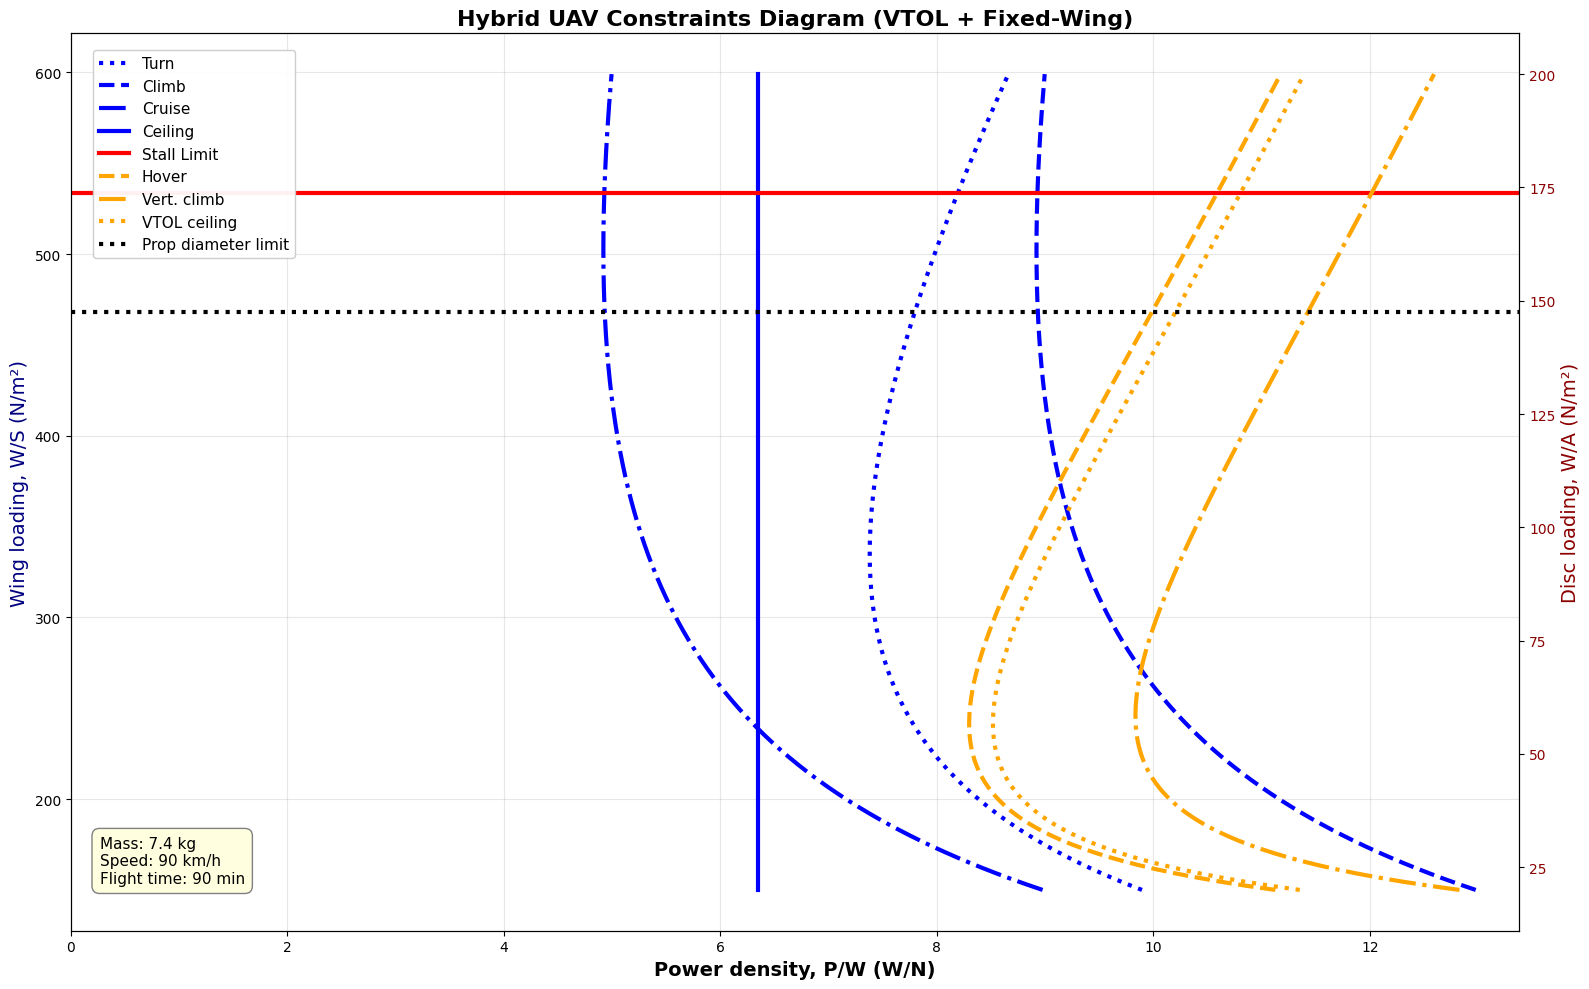


→ Plotting airplane three-view...


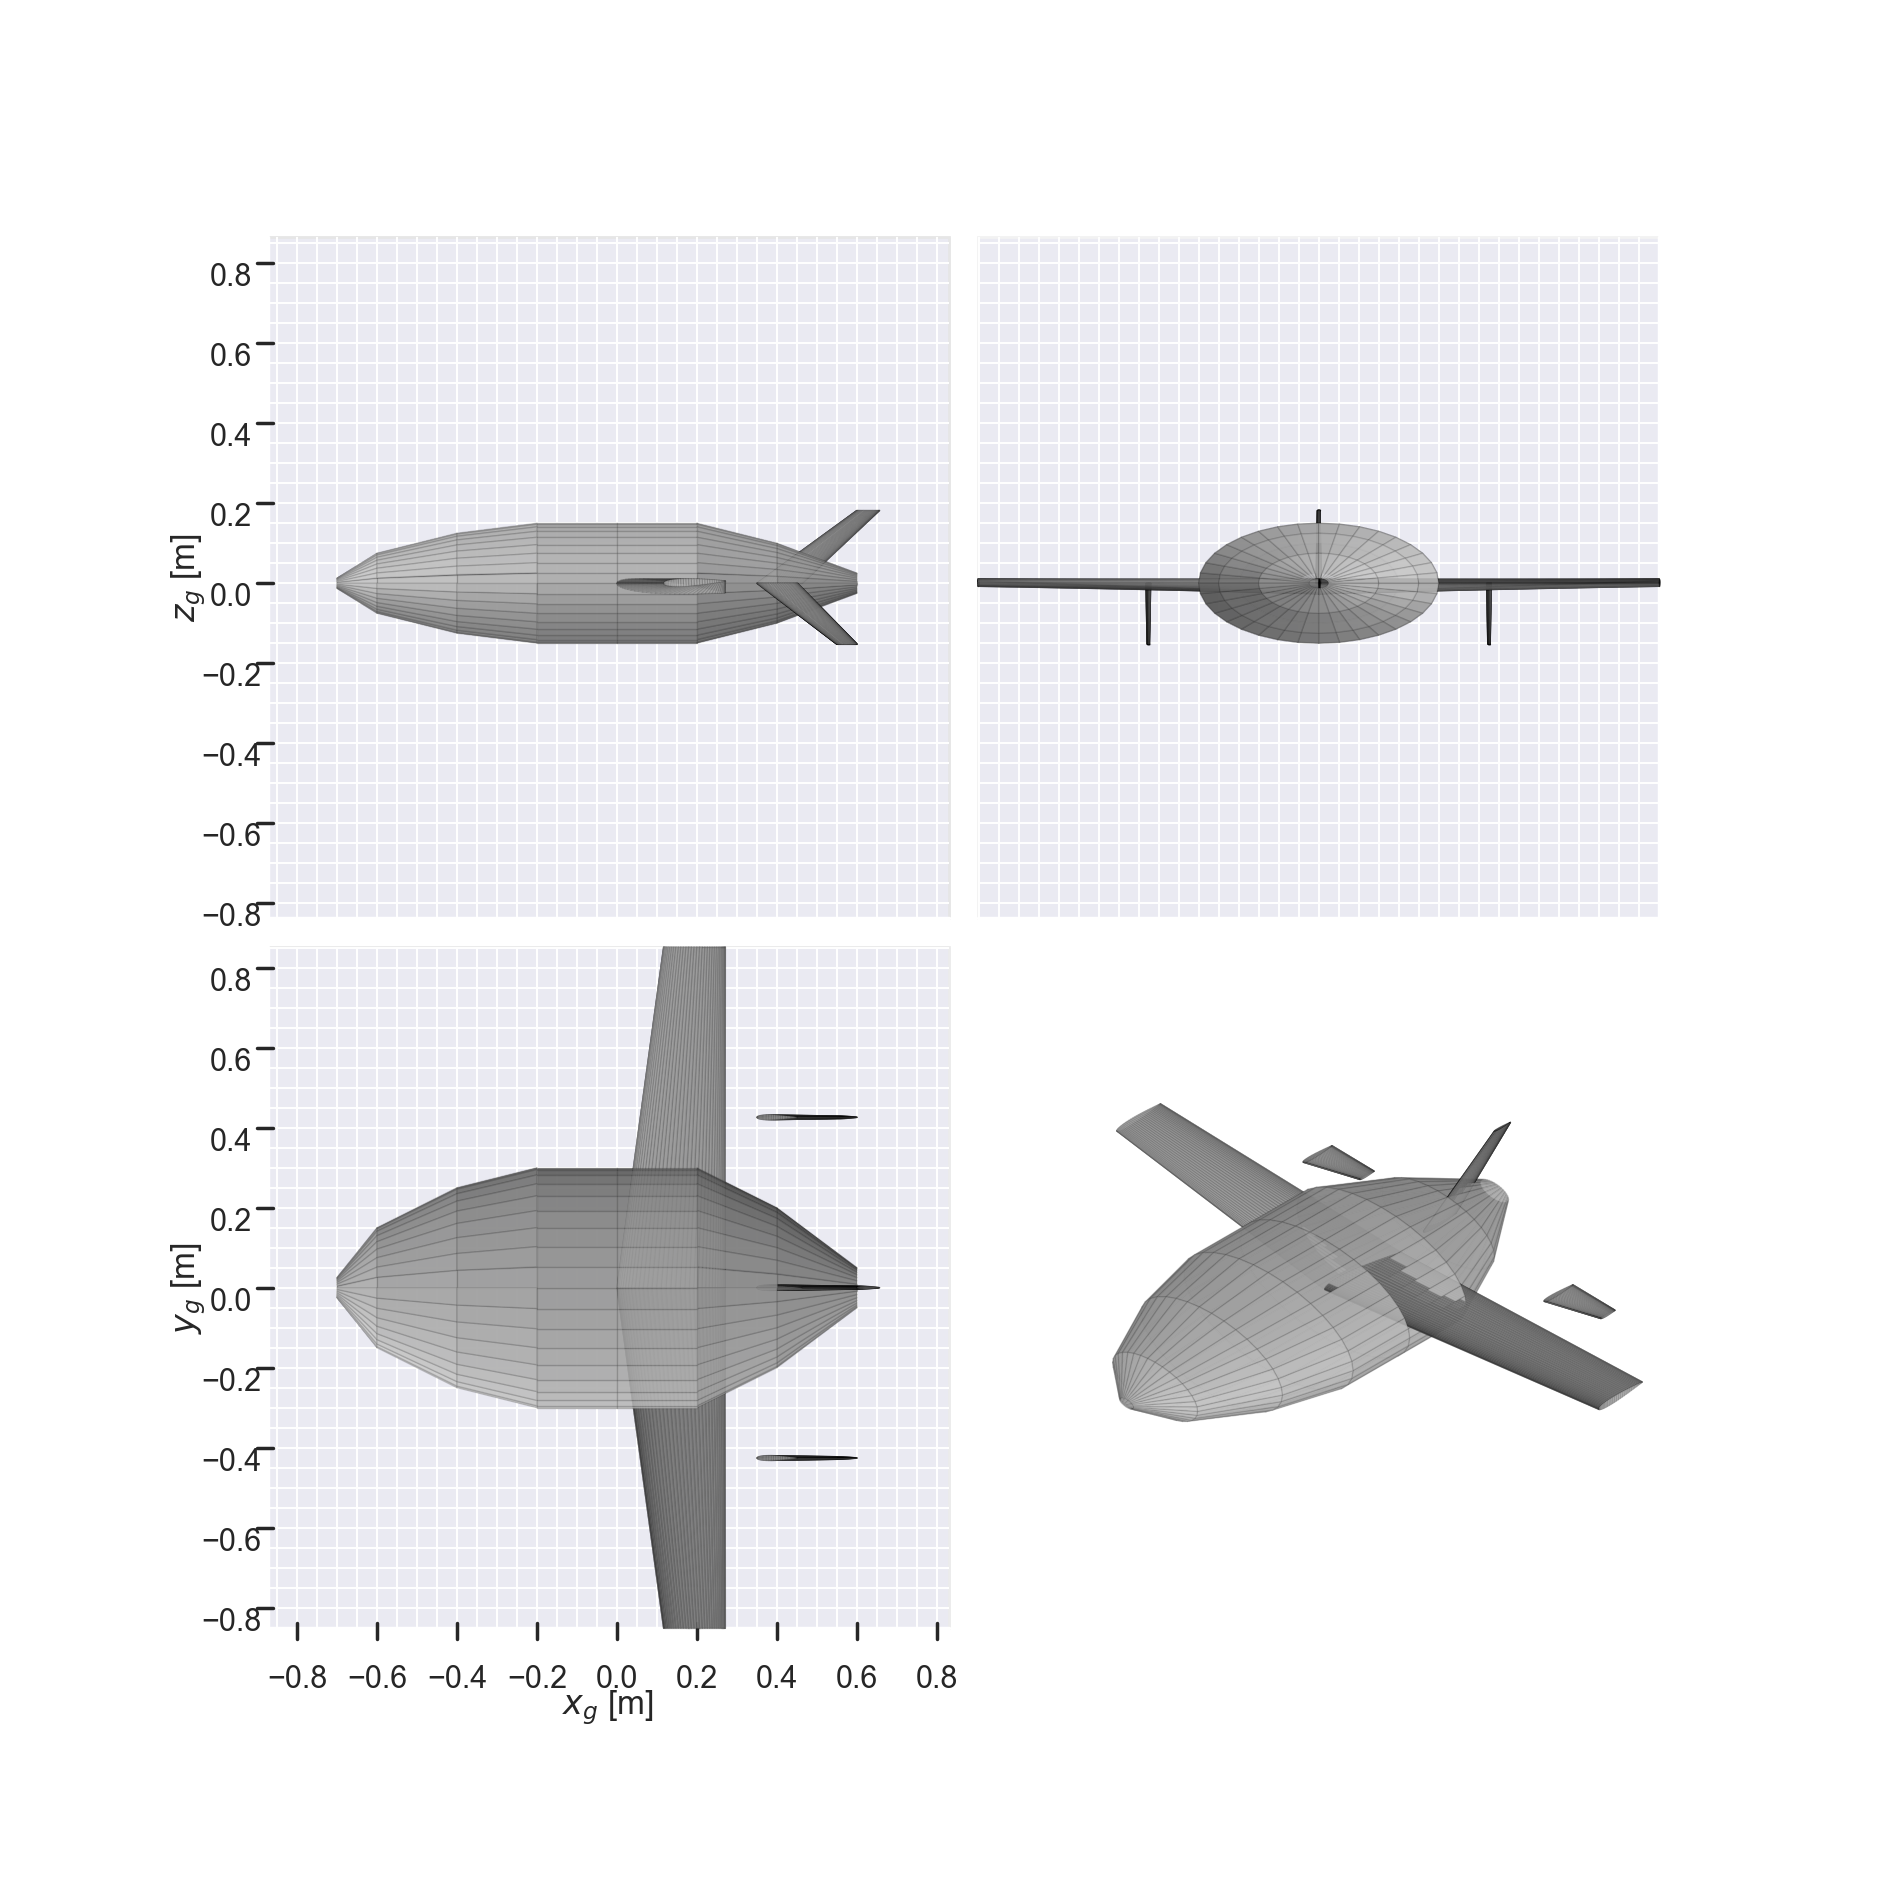


                             DESIGN SUMMARY REPORT                              

╔════════════════════════════════════════════════════════════════════════════╗
║                         HYBRID VTOL + FIXED-WING UAV                       ║
╚════════════════════════════════════════════════════════════════════════════╝

📦 MASS BREAKDOWN
  ├─ Takeoff Mass:        7.40 kg
  ├─ Battery Mass:        1.32 kg
  ├─ Powerplant Mass:     1.59 kg
  └─ Payload Mass:        1.50 kg

✈️  WING PARAMETERS
  ├─ Wing Area:           0.363 m²
  ├─ Wingspan:            1.704 m
  ├─ Mean Aero Chord:     0.218 m
  ├─ Aspect Ratio:        8.0
  ├─ Taper Ratio:         0.57
  └─ Root/Tip Chord:      0.271 / 0.155 m

⚡ POWER & PERFORMANCE
  ├─ Required Power:      172 W
  ├─ Cruise Speed:        90 km/h (25.0 m/s)
  ├─ Stall Speed:         55 km/h (15.3 m/s)
  ├─ L/D Optimal:         6.78
  └─ Flight Time:         90 min

🔋 BATTERY PACK
  ├─ Total Cells:         24
  ├─ Pack Voltage:        25.2 V
  ├─ Capacit

In [26]:
# ============================================================================
# MAIN EXECUTION BLOCK - Run all calculations
# ============================================================================

print("\n" + "="*80)
print("STARTING UAV DESIGN CALCULATION".center(80))
print("="*80)

# ============================================================================
# STEP 1: MASS CONVERGENCE
# ============================================================================
print("\n[1/7] Computing takeoff mass convergence...")
mass_result = iterate_takeoff_mass(DesignConstants, tol=0.5, max_iter=50)
m0_final = mass_result['final_m0_kg']
m_battery = mass_result['m_battery_kg']
print_mass_summary(mass_result, DesignConstants)

# ============================================================================
# STEP 2: WING LOADING AND STALL CONDITIONS
# ============================================================================
print("\n[2/7] Computing wing loading parameters...")
wing_load_params = calculate_wing_loading_params(DesignConstants)
wing_loading = wing_load_params['wing_loading']
print(f"✓ Stall speed: {wing_load_params['stall_speed_ms']:.2f} m/s")
print(f"✓ Wing loading at stall: {wing_loading:.1f} N/m²")

# ============================================================================
# STEP 3: WING GEOMETRY
# ============================================================================
print("\n[3/7] Computing wing geometry...")
wing_geo = calculate_wing_geometry(m0_final, wing_loading, DesignConstants)
print(f"✓ Wing area: {wing_geo['S_wing']:.3f} m²")
print(f"✓ Wingspan: {wing_geo['wingspan']:.3f} m")
print(f"✓ Root chord: {wing_geo['root_chord']:.3f} m")
print(f"✓ Tip chord: {wing_geo['tip_chord']:.3f} m")
print(f"✓ MAC: {wing_geo['MAC']:.3f} m")

# ============================================================================
# STEP 4: CRUISE AERODYNAMICS
# ============================================================================
print("\n[4/7] Computing cruise aerodynamics...")
aero_params = calculate_cruise_aerodynamics(DesignConstants, wing_geo)
print(f"✓ Zero-lift drag coefficient: {aero_params['zero_lift_drag']:.5f}")
print(f"✓ Induced drag factor K: {aero_params['induced_drag_factor_K']:.5f}")
print(f"✓ Optimal L/D: {aero_params['aerodynamic_quality']:.2f}")

# ============================================================================
# STEP 5: BATTERY PARAMETERS
# ============================================================================
print("\n[5/7] Computing battery parameters...")
battery_params = calculate_battery_params(DesignConstants, m_battery)
print_battery_summary(battery_params)

# ============================================================================
# STEP 6: WING CHARACTERISTICS
# ============================================================================
print("\n[6/7] Computing wing characteristics and polar...")
wing_chars = calculate_wing_characteristics(DesignConstants, wing_geo)
wing_polar = calculate_wing_polar(DesignConstants, wing_chars)
print(f"✓ Max lift coefficient: {wing_chars['max_lift_coeff']:.3f}")
print(f"✓ Critical angle: {wing_chars['critical_angle']:.1f}°")

# ============================================================================
# STEP 7: VERTICAL STABILIZER
# ============================================================================
print("\n[7/7] Computing vertical stabilizer...")
vstab_geo = calculate_vertical_stabilizer(wing_geo['wingspan'], wing_geo['S_wing'], DesignConstants)
print(f"✓ Vertical stabilizer area: {vstab_geo['total_area']:.3f} m²")
print(f"✓ Scale factor (central): {vstab_geo['scale_central']:.3f}x")
print(f"✓ Scale factor (sides): {vstab_geo['scale_side']:.3f}x")

# ============================================================================
# GENERATE VISUALIZATIONS
# ============================================================================
print("\n" + "="*80)
print("GENERATING VISUALIZATIONS".center(80))
print("="*80)

# 1. Wing Profile
print("\n→ Plotting airfoil profile...")
profile_data = calculate_airfoil_coordinates(DesignConstants)
plot_airfoil_profile(profile_data)

# 2. Wing Polar
print("\n→ Plotting wing drag polar...")
plot_wing_polar(wing_polar)

# 3. Constraint Diagram
print("\n→ Plotting constraint diagram...")
constraints = calculate_constraint_diagram(DesignConstants, m0_final, wing_geo, aero_params)
plot_constraint_diagram(constraints, m0_final, DesignConstants)

# 4. Airplane 3-View
print("\n→ Plotting airplane three-view...")
airplane = build_airplane_model(DesignConstants, wing_geo, vstab_geo)
plot_airplane_views(airplane)

# ============================================================================
# SUMMARY REPORT
# ============================================================================
print("\n" + "="*80)
print("DESIGN SUMMARY REPORT".center(80))
print("="*80)

summary_report = f"""
╔════════════════════════════════════════════════════════════════════════════╗
║                         HYBRID VTOL + FIXED-WING UAV                       ║
╚════════════════════════════════════════════════════════════════════════════╝

📦 MASS BREAKDOWN
  ├─ Takeoff Mass:        {m0_final:.2f} kg
  ├─ Battery Mass:        {m_battery:.2f} kg
  ├─ Powerplant Mass:     {mass_result['m_powerplant_kg']:.2f} kg
  └─ Payload Mass:        {DesignConstants.payload_mass:.2f} kg

✈️  WING PARAMETERS
  ├─ Wing Area:           {wing_geo['S_wing']:.3f} m²
  ├─ Wingspan:            {wing_geo['wingspan']:.3f} m
  ├─ Mean Aero Chord:     {wing_geo['MAC']:.3f} m
  ├─ Aspect Ratio:        {DesignConstants.AR:.1f}
  ├─ Taper Ratio:         {DesignConstants.taper_ratio:.2f}
  └─ Root/Tip Chord:      {wing_geo['root_chord']:.3f} / {wing_geo['tip_chord']:.3f} m

⚡ POWER & PERFORMANCE
  ├─ Required Power:      {mass_result['P_req_W']:.0f} W
  ├─ Cruise Speed:        {DesignConstants.cruise_speed} km/h ({DesignConstants.cruise_speed_ms:.1f} m/s)
  ├─ Stall Speed:         {DesignConstants.stall_speed} km/h ({wing_load_params['stall_speed_ms']:.1f} m/s)
  ├─ L/D Optimal:         {aero_params['aerodynamic_quality']:.2f}
  └─ Flight Time:         {DesignConstants.flight_time} min

🔋 BATTERY PACK
  ├─ Total Cells:         {battery_params['cell_total']}
  ├─ Pack Voltage:        {battery_params['pack_U']:.1f} V
  ├─ Capacity:            {battery_params['pack_capacity_Ah']:.1f} Ah
  └─ Mass:                {battery_params['pack_mass']:.3f} kg

🎯 VERTICAL STABILIZER
  ├─ Total Area:          {vstab_geo['total_area']:.3f} m²
  ├─ Central Fin Area:    {vstab_geo['S_central']:.3f} m²
  ├─ Side Fins Area:      {vstab_geo['S_side']:.3f} m² (each)
  └─ Span:                {vstab_geo['span']:.3f} m
"""

print(summary_report)
print("="*80)
print("✓ All calculations completed successfully!".center(80))
print("="*80 + "\n")